# Exploratory data analysis (EDA)

## Preparations

For the preparations lets first import the necessary libraries and load the files needed for our EDA

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

from loguru import logger
import os
from pathlib import Path

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

In [2]:
def get_endindex(lst: list, value):
    """
    This function takes a list and a value as input, and returns the next value
    after the given one.
    Args:
        lst: list 
        value: value which will be searched in the list
    Return: 
        Next value in list or None (if not found or last element in list)
    """
    # Get the index of the given value in the list
    try:
        index = lst.index(value)
    except ValueError:
        return None
    
    # If the given value is the last element in the list, return None
    if index == len(lst) - 1:
        return None
    
    # Otherwise, return the next value in the list
    return lst[index + 1]

In [3]:
def car_part_selection(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    This function selects the car parts from a dataframe of car structure and returns a new dataframe with only the selected modules.
    Args:
        dataframe: The initial dataframe containing the car structure with all car parts and the metadata.
    Return:
        dataframe_new: A new dataframe containing only the car parts on the last level of the car structure with "Dok-Format" equals to "5P" and the selected modules.
    '''
    # Initialize an empty dataframe with the same columns as the given one
    dataframe_new = pd.DataFrame(columns=dataframe.columns)

    keep_modules = ["FBEP", "CE05", "CD07"]
    # Iterate over each module which should be kept
    for module in keep_modules:
        endindex = -1
        try: 
            # Iterate over each sample where the module number equals the module which should be kept.
            # It stores all car parts which are in the module to the new dataframe
            for i in range(dataframe[dataframe["Modul (Nr)"] == module].shape[0]):
                level = dataframe[dataframe["Modul (Nr)"] == module]["Ebene"].values[i]
                startindex = dataframe[dataframe["Modul (Nr)"] == module].index[i]
                if startindex > endindex:
                    try:
                        modules_on_same_level = dataframe[dataframe["Ebene"] == level].index.tolist()
                        endindex = get_endindex(modules_on_same_level, startindex)
                    except: 
                        endindex = dataframe.shape[0] + 1
                    temp = dataframe.loc[startindex:endindex]
                    dataframe_new = pd.concat([dataframe_new, temp], ignore_index=True).reset_index(drop=True)

        except:
            logger.info(f"Module {module} not found in the structure tree!")

    # Keep only the relevant samples with Dok-Format=5P. These are on the last level of the car structure and contains only car parts
    dataframe_new = dataframe_new[dataframe_new["Dok-Format"]=='5P'].reset_index(drop=True)

    return dataframe_new


In [4]:
def read_file(file_path, raw):
    if raw:
        # Load the excel into a pandas dataframe, delete the header and declare the second row as new header

        df = pd.read_excel(file_path, header=None, skiprows=1)
        df.columns = df.iloc[0]
        df = df.iloc[1:]

        # Drop all empty columns
        df = df.dropna(how= "all", axis=1, inplace=False)

        # Store the ncar abbreviation for file paths
        ncar = df.iloc[0]['Code']

    else:
        df = pd.read_csv(file_path)
        filename = os.path.split(file_path)[1]
        ncar = filename.split("_")[0]
        df["Derivat"] = ncar
    
    return df, ncar

In [5]:
def load_data_into_df(raw: bool) -> tuple[list, str]:
    ''' 
    This function loads data from the specified folder path. It reads data from all files in the folder, converts them to pandas dataframes and stores the dataframes in a list. 
    The list of dataframes and a list of associated NCAR codes are returned as outputs. 
    Args:
        None
    Return:
        dataframes: a list containing pandas dataframes of all the files read from the specified folder path
        ncars: a list of the associated NCAR codes for all the files in the dataframes 
    '''

    if raw:
        folder_name = Path("../data/analyze")
    else:
        folder_name = Path("../data/labeled")

    # Check if the folder exists   
    if not os.path.exists(folder_name):
        logger.info(f"The path {folder_name} does not exist.")
        exit()
    else:
        logger.info("Loading the labeled datasets...")

        # Create an empty list to store all dataframes
        dataframes = []
        ncars = []
        # Loop through all files in the folder and open them as dataframes
        for file in os.listdir(folder_name):
                try:
                    file_path = os.path.join(folder_name, file)
                    df, ncar = read_file(file_path, raw)
                except:
                    logger.info(f"Error reading file {file}. Skipping...")
                    continue

                # Add the created dataframe to the list of dataframes
                dataframes.append(df)
                ncars.append(ncar)


    # Check if any dataframes were created
    if len(dataframes) == 0:
        logger.info(f"No dataframes were created - please check if the files in folder {folder_name} are correct/exist.")
        exit()
    else:
        logger.success(f"{len(dataframes)} dataframe(s) were created.")

        return dataframes, ncars

In [6]:
dataframes, ncars = load_data_into_df(raw=True)

2023-11-05 20:21:39.493 | INFO     | __main__:load_data_into_df:22 - Loading the labeled datasets...
2023-11-05 20:21:47.987 | SUCCESS  | __main__:load_data_into_df:46 - 1 dataframe(s) were created.


In [7]:
def combine_dataframes(dataframes: list) -> pd.DataFrame:
    '''
    The function takes a list of pandas DataFrames and combines them into a single data frame. Before merging, it checks if all dataframes have the same columns and returns an error if there are discrepancies. 
    If any NaN values exist in the input data frames, it uses the check_nan_values function to obtain the list of columns with the NaN values. 
    It returns a single merged dataframe containing all columns from all input data frames. 
    Args: 
        dataframes: A list of pandas DataFrame objects. 
    Return: 
        merged_df: A single pandas DataFrame object that contains all rows and columns from all input data frames
    '''
    # Set the header information
    logger.info("Combine all datasets to one...")

    # Merge all dataframes into a single dataframe
    merged_df = pd.concat(dataframes).reset_index(drop=True)
    
    logger.success(f"{len(dataframes)} dataframe(s) are combined to one dataset.")
    
    return merged_df   

In [8]:
merged_df = combine_dataframes(dataframes)

2023-11-05 20:21:48.047 | INFO     | __main__:combine_dataframes:12 - Combine all datasets to one...
2023-11-05 20:21:48.077 | SUCCESS  | __main__:combine_dataframes:17 - 1 dataframe(s) are combined to one dataset.


# Analysis

In [9]:
merged_df.head()

,Ebene,Sachnummer,Benennung (dt),AI,Zeichnungsindex,Doku-Teil,Alternative,Dok-Format,Dok-Typ,Status,...,VC,Vergabemodell,Vers. Eigentümer Abteilung,Vers. Eigentümer Name,Vers. Eigentümer Vorname,VersionsId,Versionsreife,ZfE,Zielreife,Änderungsart
0,1,0355704,G15 VIRTUELLES GESAMTFAHRZEUG,NaN,A,1,A,ST,PACKAG,NaN,...,J,NaN,EG-235,ANONYMISIERT,NaN,10771115,KONZ,Nein,NaN,NaN
1,2,P0ZBXT7,G15 VPBG (VIRT.PRODUKTIONSBAUGRUPPE),NaN,A,1,A,ST,PACKAG,NaN,...,N,NaN,EG-235,SALAMON,PHILIP,25650128,KONZ,Nein,NaN,NaN
2,3,P065GF3,G15 SONDERZUBEHOER (SZ),NaN,A,1,A,ST,PACKAG,NaN,...,NaN,NaN,CP-151,FINKE,CARSTEN,18636479,KONZ,Nein,NaN,NaN
3,3,P0ZBXV2,G15 VPBG SALAVA,NaN,A,1,A,ST,PACKAG,NaN,...,N,NaN,EG-235,SALAMON,PHILIP,25650143,KONZ,Nein,NaN,NaN
4,3,P1QWFD4,G15 VPBG B57D30T2 R ECE AWD BC62,NaN,A,1,A,ST,PACKAG,NaN,...,N,NaN,EG-235,GAERTNER,RAFFAELA,32233579,KONZ,Nein,NaN,NaN


### Check missing values

In [10]:
# Select specified modules 
prepared_df = car_part_selection(merged_df)


In [11]:
prepared_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 104 columns):
 #    Column                      Non-Null Count  Dtype 
---   ------                      --------------  ----- 
 0    Ebene                       2516 non-null   object
 1    Sachnummer                  2516 non-null   object
 2    Benennung (dt)              2516 non-null   object
 3    AI                          2312 non-null   object
 4    Zeichnungsindex             2516 non-null   object
 5    Doku-Teil                   2516 non-null   object
 6    Alternative                 2516 non-null   object
 7    Dok-Format                  2516 non-null   object
 8    Dok-Typ                     2516 non-null   object
 9    Status                      2516 non-null   object
 10   Dok-Reife                   2516 non-null   object
 11   Kommentar                   1454 non-null   object
 12   1. Typ                      2387 non-null   object
 13   AENST                       251

### Feature pre-selection

In [12]:
list_features = [
  "Ebene", 
  "Sachnummer", 
  "Benennung (dt)", 
  "Zeichnungsindex", 
  "Doku-Teil", 
  "Alternative", 
  "Dok-Format", 
  "X-Min", 
  "X-Max", 
  "Y-Min",
  "Y-Max",
  "Z-Min",
  "Z-Max",
  "ox",
  "oy",
  "oz",
  "xx",
  "xy",
  "xz",
  "yx",
  "yy",
  "yz",
  "zx",
  "zy",
  "zz",
  "Wert",
  "Einheit",
  "Gewichtsart",
  "L-Kz.",
  "Kurzname",
  "L/R-Kz.",
  "Modul (Nr)",
  "Code"
  ]

In [13]:
def remove_nan_features(df):
   """
   Removes all features (columns) from the input dataframe that have more than 20% NaN values.
   Returns the resulting dataframe.
   """
   threshold = 1  # 20% threshold
   num_rows = df.shape[0]
   nan_counts = df.isnull().sum()
   nan_percentages = nan_counts / num_rows
   features_to_drop = nan_percentages[nan_percentages > threshold].index
   df = df.drop(features_to_drop, axis=1)
   return df

In [14]:
reduced_df = remove_nan_features(prepared_df)

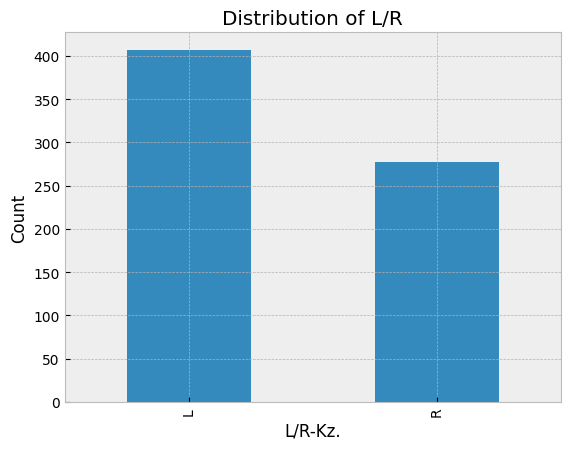

In [15]:
# use value_counts to count the occurrences of each unique value in the 'fruit' column
counts = reduced_df['L/R-Kz.'].value_counts()

# create a bar chart of the counts
counts.plot(kind='bar')

# add axis labels and a title to the plot
#plt.xlabel('Fruit')
plt.ylabel('Count')
plt.title('Distribution of L/R')
plt.show()

### Convert numerical features

In [16]:
def convert_columns_to_float(df, columns):
   for col in columns:
       df[col] = pd.to_numeric(df[col], errors='coerce')
       df[col] = df[col].astype(float)
   return df

In [17]:
numerical_cols = ['X-Min', 'X-Max', 'Y-Min', 'Y-Max', 'Z-Min', 'Z-Max', 'ox', 'oy', 'oz', 'xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz', 'Wert']

In [18]:
reduced_df_float = convert_columns_to_float(reduced_df, numerical_cols)

### Analysis with boxplots and distributions

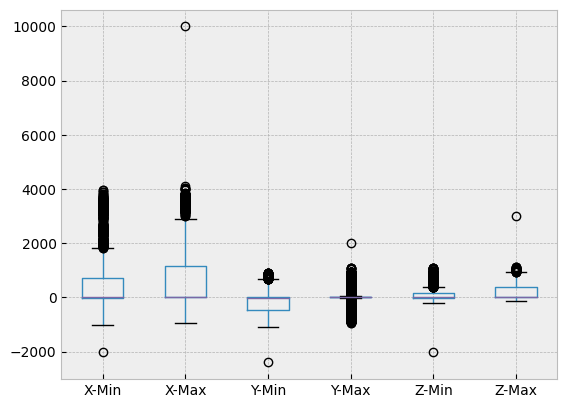

In [19]:
boxplot = reduced_df_float.boxplot(column=['X-Min', 'X-Max', 'Y-Min', 'Y-Max', 'Z-Min', 'Z-Max'])

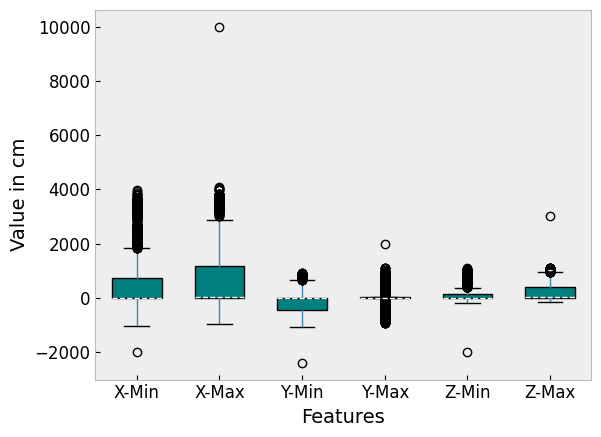

In [21]:
# create a boxplot with customized options
boxplot = reduced_df_float.boxplot(column=['X-Min', 'X-Max', 'Y-Min', 'Y-Max', 'Z-Min', 'Z-Max'], grid=False, widths=0.6,
                    fontsize=12, notch=False, patch_artist=True, 
                    boxprops=dict(facecolor='#007F7F'), 
                    medianprops=dict(linestyle='--', linewidth=1, color='white'))

# add title and axis labels
plt.xlabel("Features", fontsize=14)
plt.ylabel("Value in cm", fontsize=14)

plt.savefig('boxplot_boundingbox.svg', format='svg')

C:\Users\q617269\AppData\Local\Temp\ipykernel_14752\101278883.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(reduced_df_float[['X-Min', 'X-Max']], color='#007F7F', bins=100, hist_kws={'alpha': 0.4})


<Axes: ylabel='Density'>

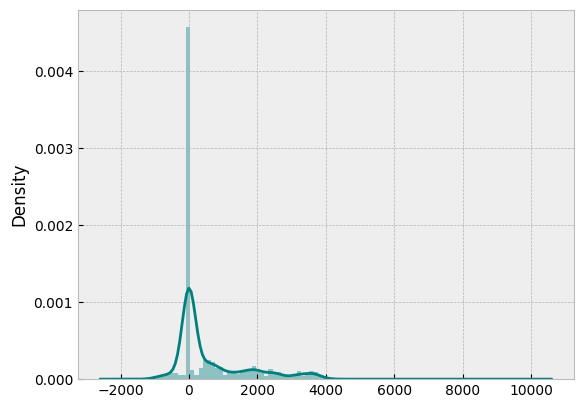

In [22]:
sns.distplot(reduced_df_float[['X-Min', 'X-Max']], color='#007F7F', bins=100, hist_kws={'alpha': 0.4})

C:\Users\q617269\AppData\Local\Temp\ipykernel_14752\4109318710.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(reduced_df_float[[feature]], color='#007F7F', bins=100, hist_kws={'alpha': 0.4}, ax=axs[i])
C:\Users\q617269\AppData\Local\Temp\ipykernel_14752\4109318710.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad63727

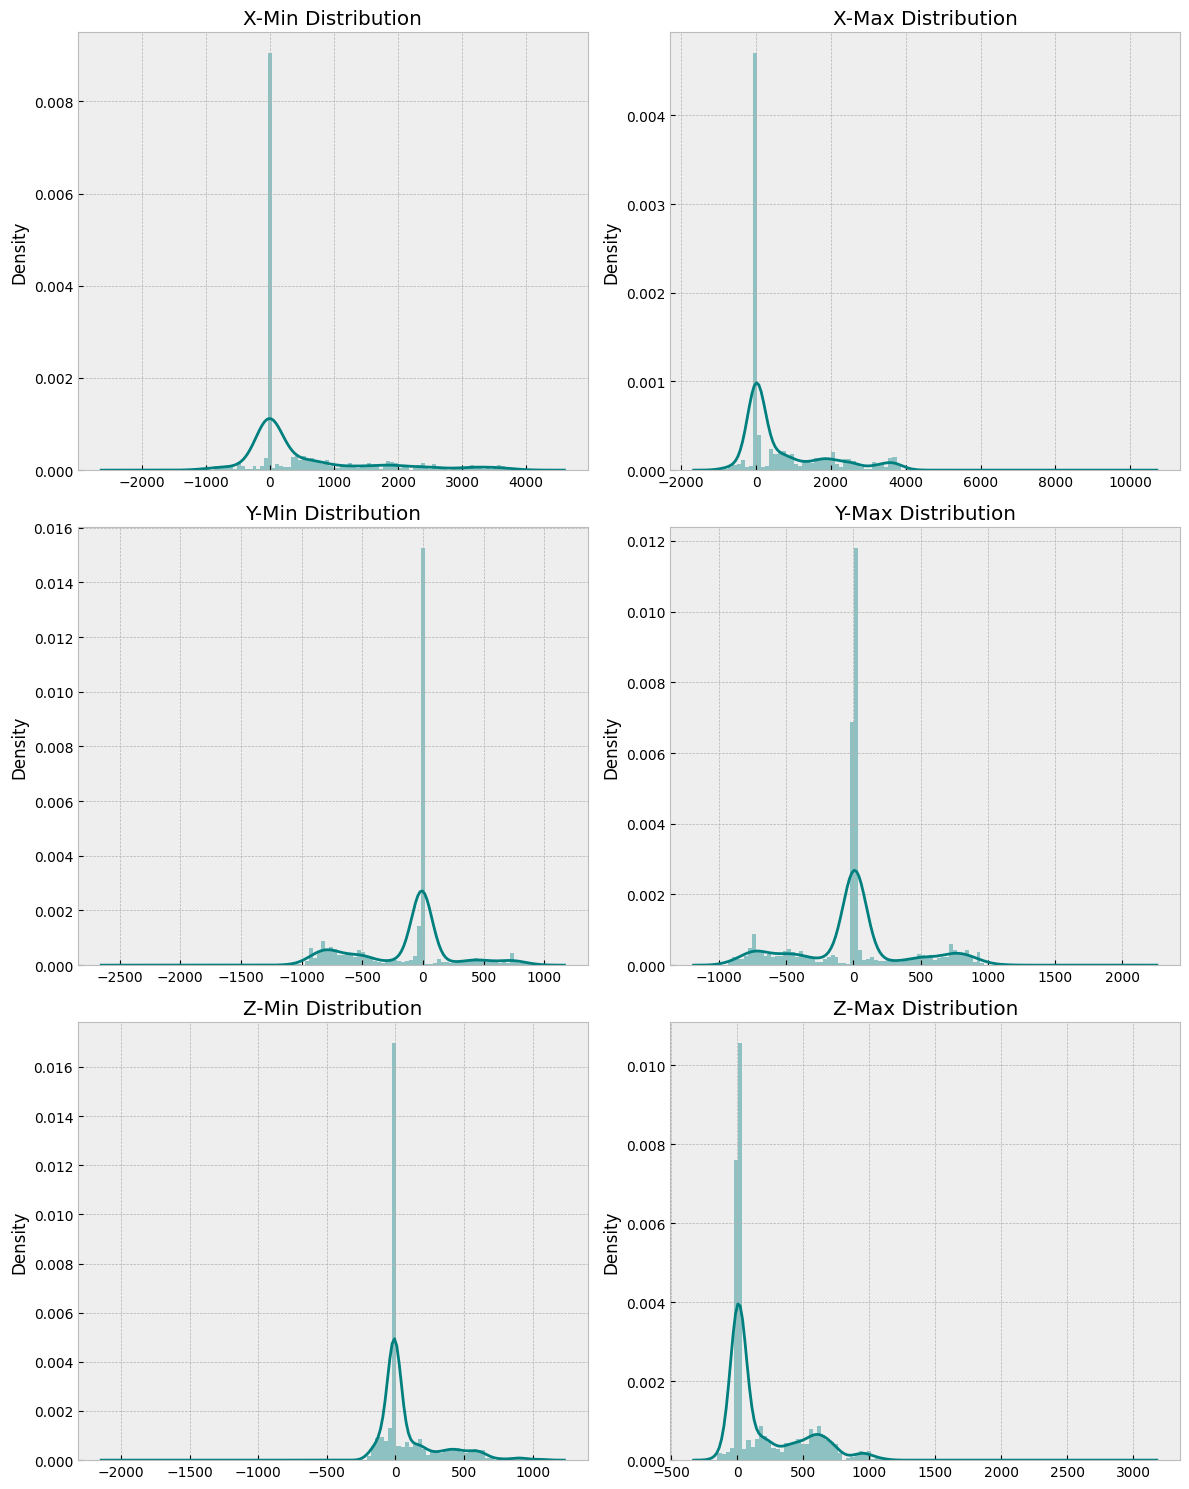

<Figure size 640x480 with 0 Axes>

In [23]:
# Create subplots for each feature
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
axs = axs.flatten()

# Plot each feature on its own subplot
for i, feature in enumerate(['X-Min', 'X-Max', 'Y-Min', 'Y-Max', 'Z-Min', 'Z-Max']): 
   sns.distplot(reduced_df_float[[feature]], color='#007F7F', bins=100, hist_kws={'alpha': 0.4}, ax=axs[i])
   axs[i].set_title(f'{feature} Distribution')

# Adjust arrangement of subplots
plt.tight_layout()

plt.show()

plt.savefig('densityplot_boundingbox.svg', format='svg')

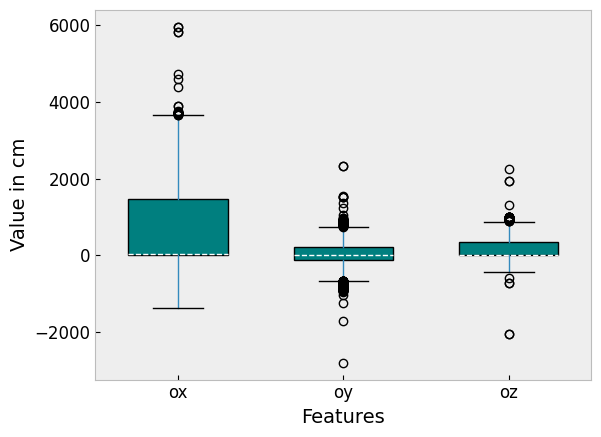

In [24]:
# create a boxplot with customized options
boxplot_locationvector = reduced_df_float.boxplot(column=['ox', 'oy', 'oz'], grid=False, widths=0.6,
                    fontsize=12, notch=False, patch_artist=True, 
                    boxprops=dict(facecolor='#007F7F'), 
                    medianprops=dict(linestyle='--', linewidth=1, color='white'))

# add title and axis labels
plt.xlabel("Features", fontsize=14)
plt.ylabel("Value in cm", fontsize=14)

plt.savefig('boxplot_locationvector.svg', format='svg')

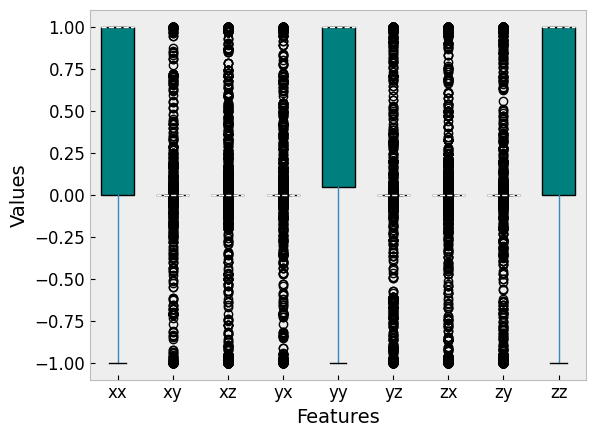

In [25]:
# create a boxplot with customized options
boxplot_locationvector = reduced_df_float.boxplot(column=['xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz'], grid=False, widths=0.6,
                    fontsize=12, notch=False, patch_artist=True, 
                    boxprops=dict(facecolor='#007F7F'), 
                    medianprops=dict(linestyle='--', linewidth=1, color='white'))

# add title and axis labels
plt.xlabel("Features", fontsize=14)
plt.ylabel("Values", fontsize=14)

plt.savefig('boxplot_rotationmatrix.svg', format='svg')

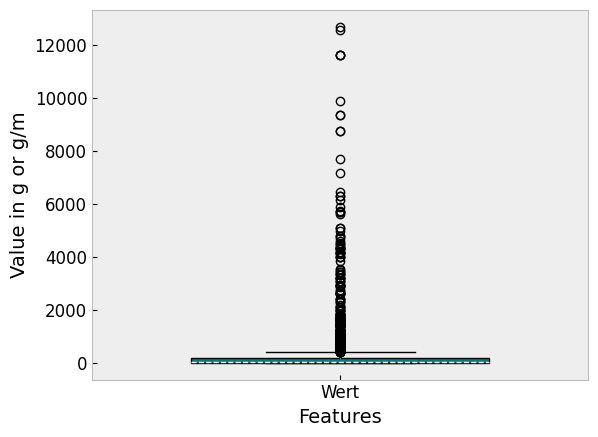

In [26]:
# create a boxplot with customized options
boxplot_weight = reduced_df_float.boxplot(column=['Wert'], grid=False, widths=0.6,
                    fontsize=12, notch=False, patch_artist=True, 
                    boxprops=dict(facecolor='#007F7F'), 
                    medianprops=dict(linestyle='--', linewidth=1, color='white'))

# add title and axis labels
plt.xlabel("Features", fontsize=14)
plt.ylabel("Value in g or g/m", fontsize=14)

plt.savefig('boxplot_Weight.svg', format='svg')

C:\Users\q617269\AppData\Local\Temp\ipykernel_6968\2421349300.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(reduced_df_float['Wert'], color='g', bins=100, hist_kws={'alpha': 0.4})


<Axes: xlabel='Wert', ylabel='Density'>

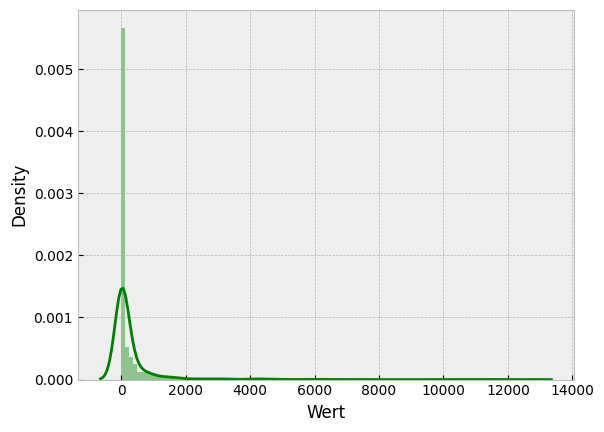

In [126]:
sns.distplot(reduced_df_float['Wert'], color='g', bins=100, hist_kws={'alpha': 0.4})

In [27]:
reduced_df_float["Einheit"].describe()

count     2421
unique       2
top          g
freq      2420
Name: Einheit, dtype: object

# Correlation

In [58]:
def calculate_correlation(df, features, name="correlation_matrix_boundingbox.svg"):
    """
    Calculates correlation between provided features of a dataframe.
    Parameters:
        df (pandas DataFrame): Dataframe containing the features.
        features (list): List of column names for which correlation is to be calculated.
    Returns:
        corrs (pandas DataFrame): DataFrame representing the correlation matrix.
    """
    # select the features of interest
    data = df[features]

    # calculate the correlation
    corrs = data.corr()

    # Set up the heatmap
    plt.figure(figsize=(20, 20))
    cmap = sns.light_palette("#007F7F", reverse=True, as_cmap=True)

    font = 22

    ax = sns.heatmap(corrs, cmap=cmap, annot=True, square=False, cbar=False, xticklabels=True, yticklabels=True, linecolor='none', annot_kws={"size": font, 'color':'black'})

    
    plt.savefig(name, format='svg', bbox_inches='tight')

    #corrs.to_excel('correlation_matrix_boundingbox.xlsx')

    return corrs

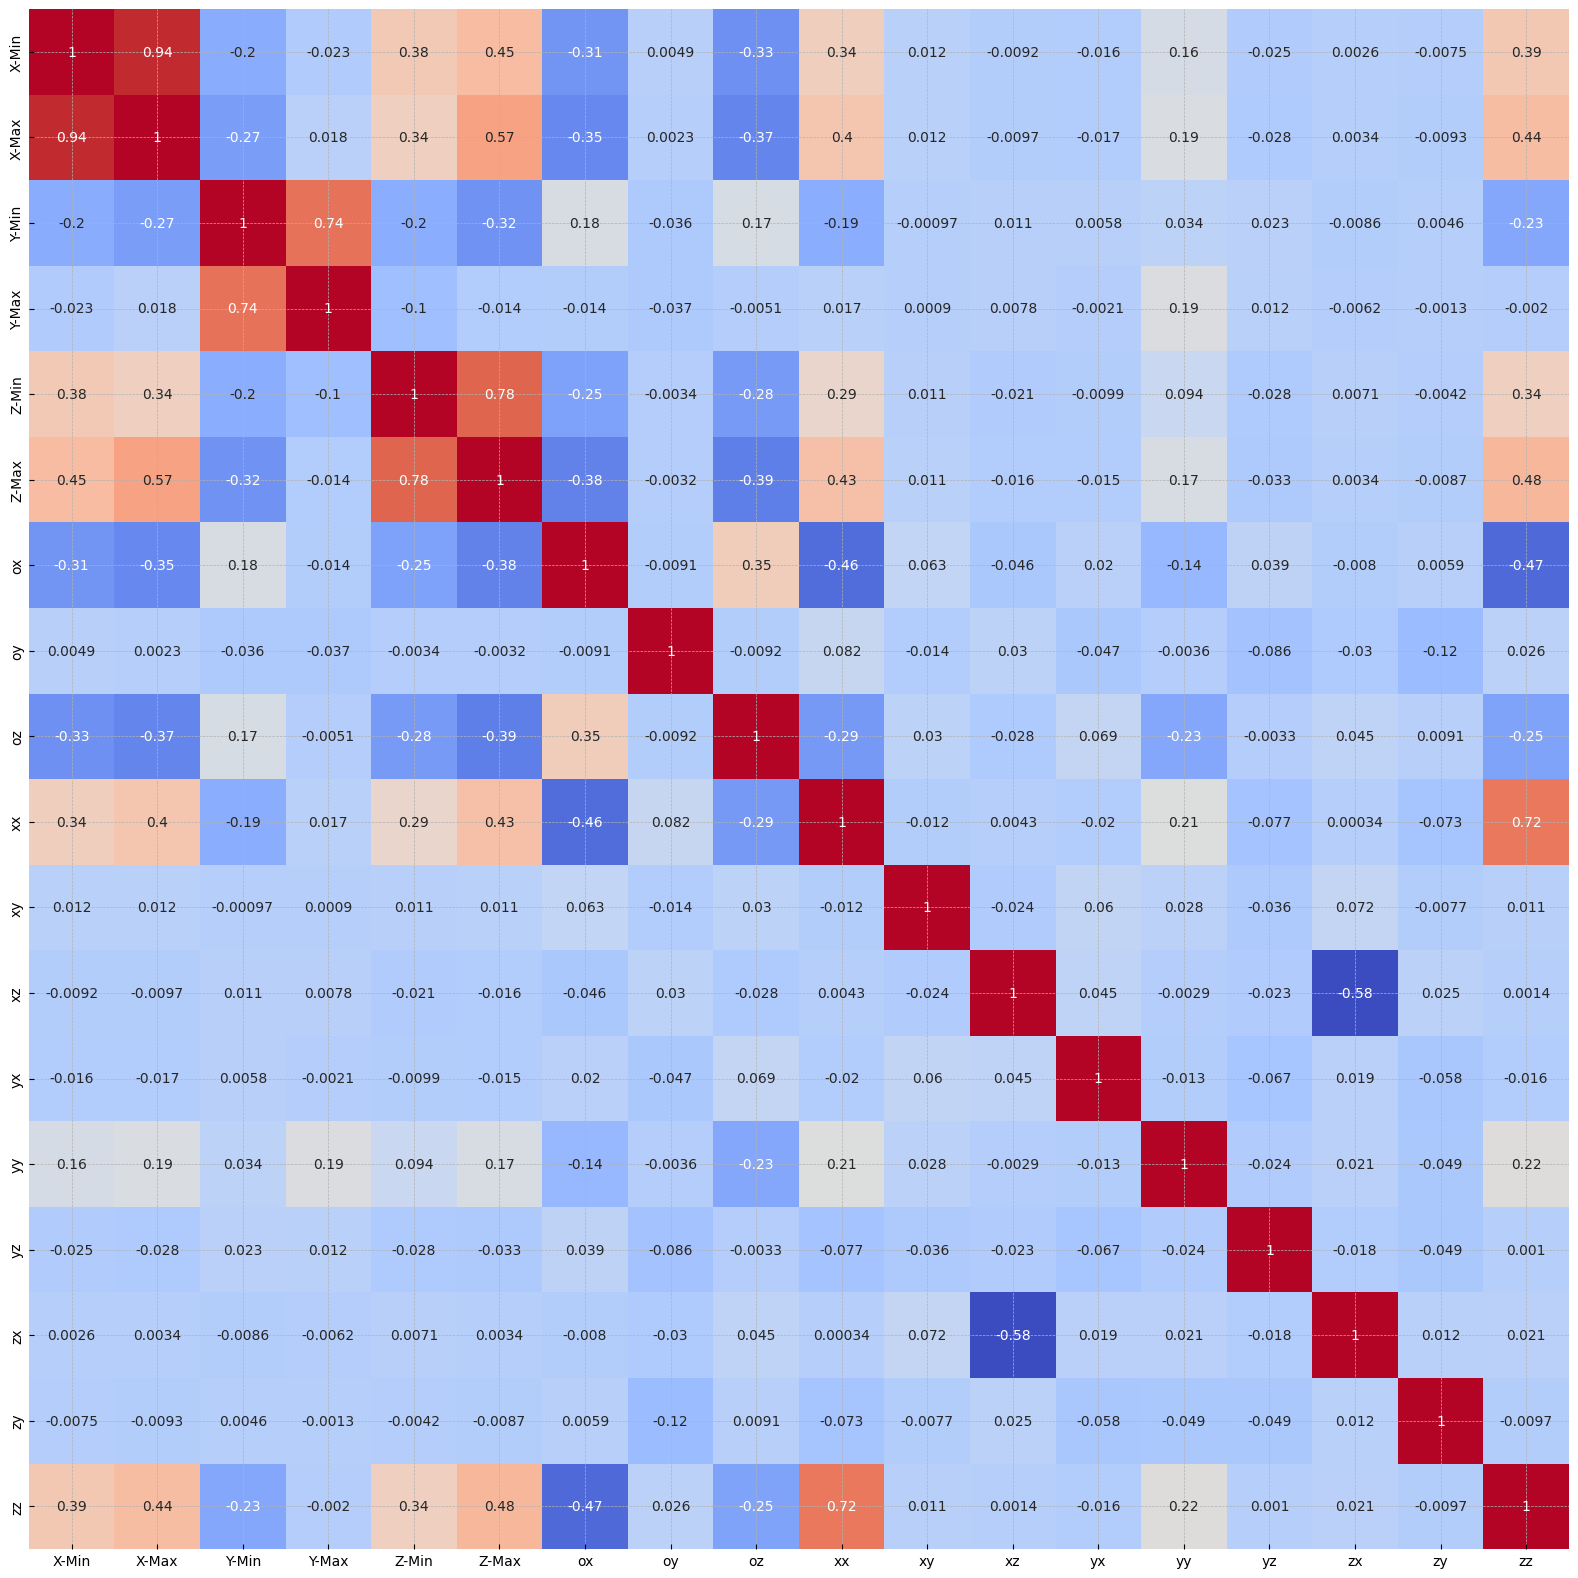

In [49]:
# calculate the correlation between feature1 and feature2
corrs = calculate_correlation(reduced_df_float, ['X-Min', 'X-Max', 'Y-Min', 'Y-Max', 'Z-Min', 'Z-Max', 'ox', 'oy', 'oz','xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz'])

Correlation of the new calculated bounding box information

In [42]:
df = pd.read_csv("../data/processed/20230901_1031/processed_dataset.csv")

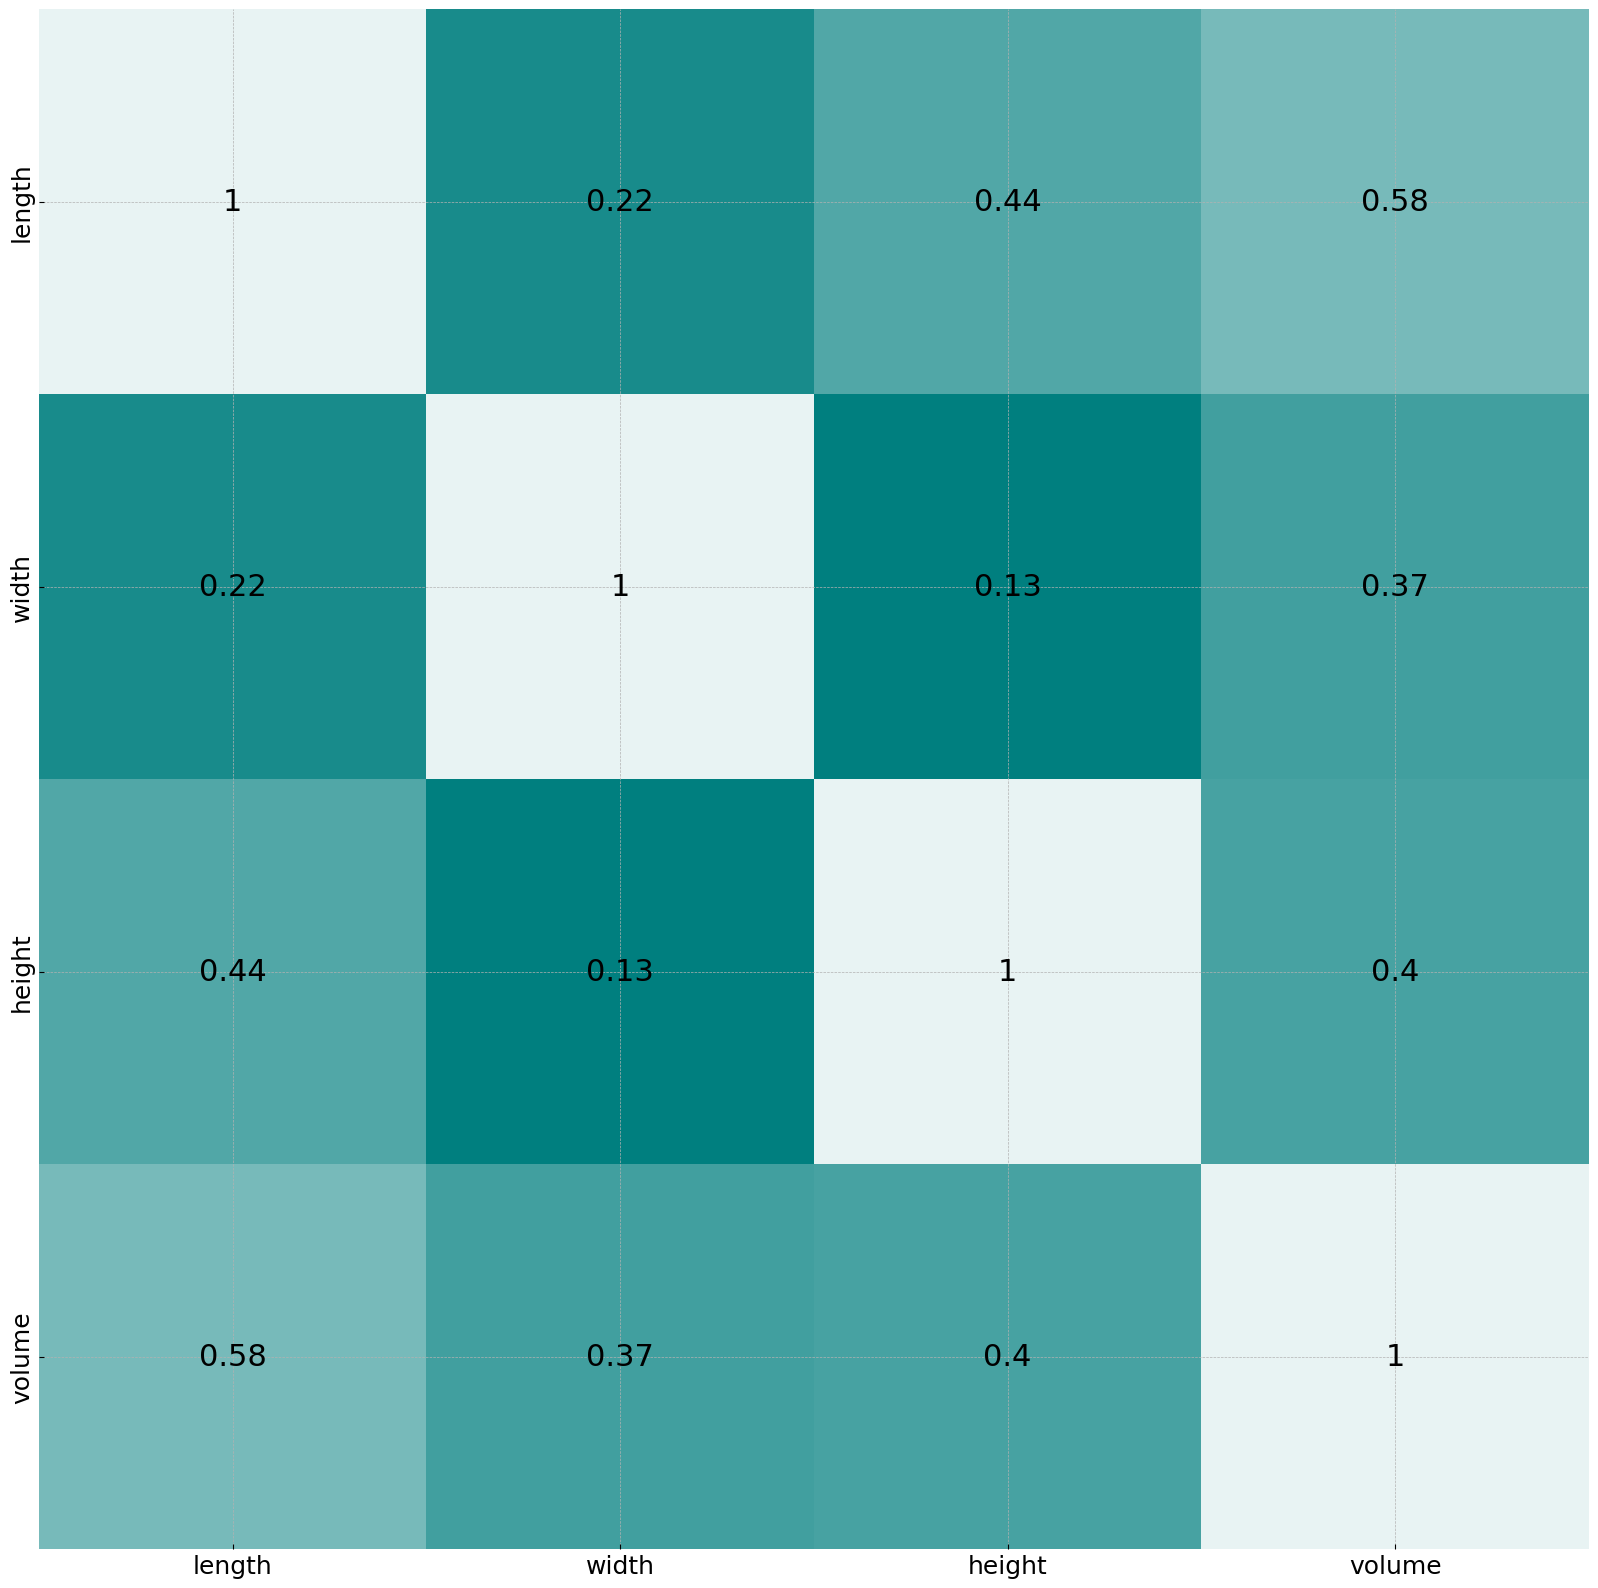

In [59]:
corrs = calculate_correlation(df, ['length', 'width', 'height', 'volume'], name="correlation_matrix_volume.svg")

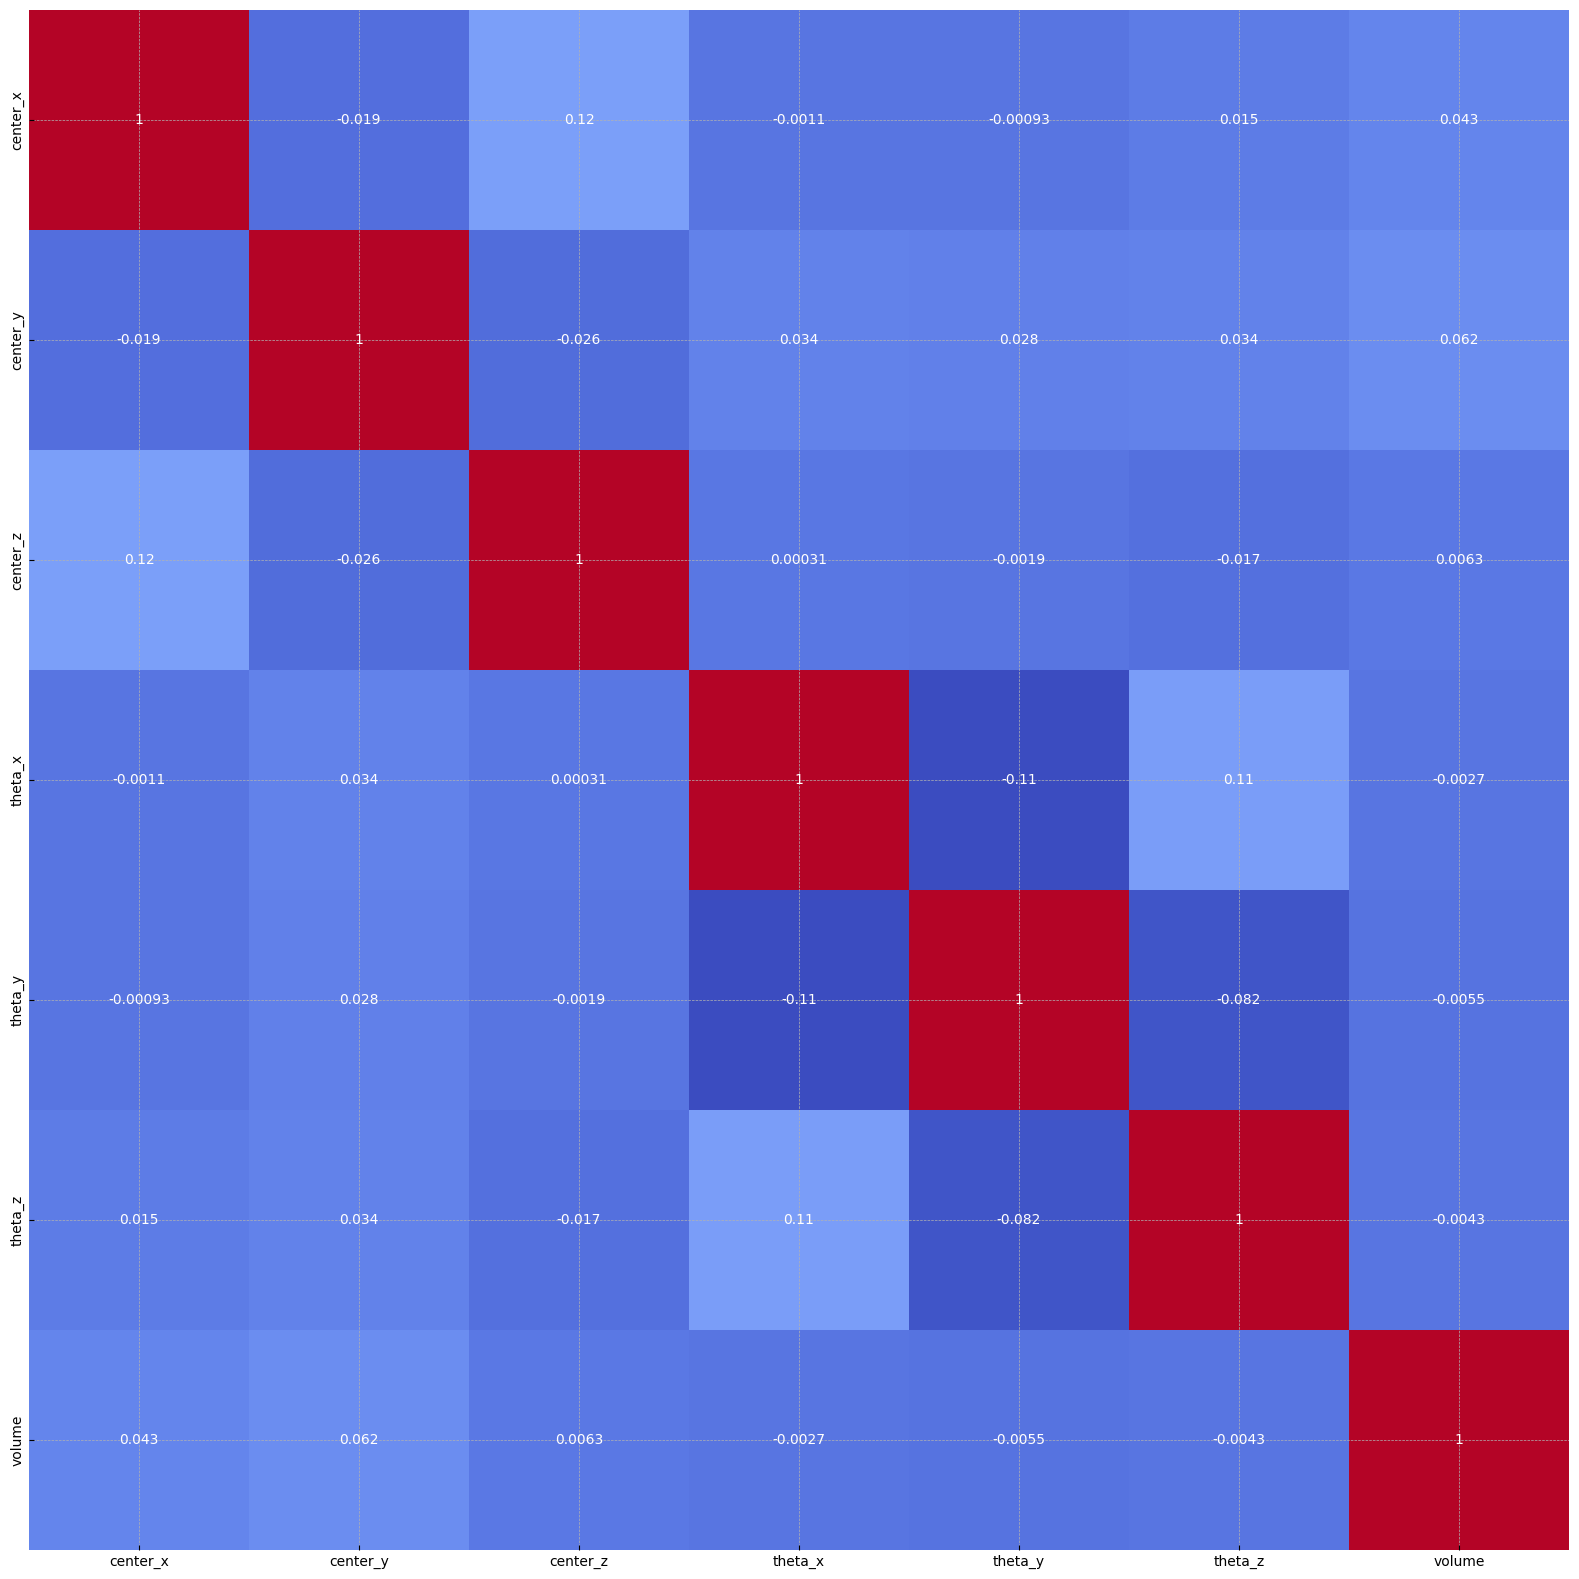

In [56]:
corrs = calculate_correlation(df, ['center_x', 'center_y', 'center_z', 'theta_x', 'theta_y', 'theta_z', 'volume'], name="correlation_matrix_newboundingbox2.svg")

In [63]:
def visualize_volume(df):
    # Filter the dataframe for components labeled as "Ja"
    ja_components = df[df["Relevant fuer Messung"] == "Ja"]

    # Filter the dataframe for components labeled as "Nein"
    nein_components = df[df["Relevant fuer Messung"] == "Nein"]

    # Plotting the histogram
    plt.hist(ja_components["volume"], bins=100, label="Ja")

    # Adding labels and legend
    plt.xlabel("Volume")
    plt.ylabel("Frequency")
    plt.legend()

    # Display the plot
    plt.show()

    plt.hist(nein_components["volume"], bins=100, label="Nein")

    # Adding labels and legend
    plt.xlabel("Volume")
    plt.ylabel("Frequency")
    plt.legend()

    # Display the plot
    plt.show()

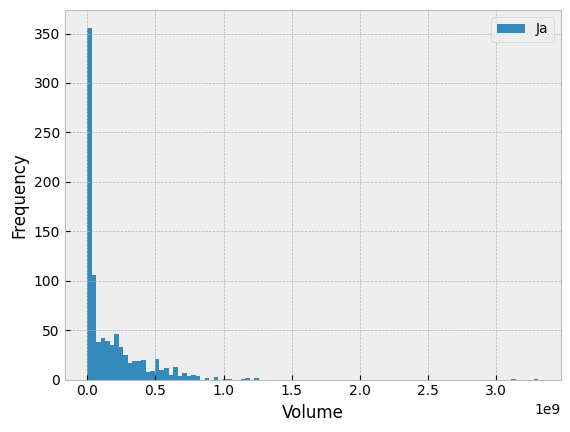

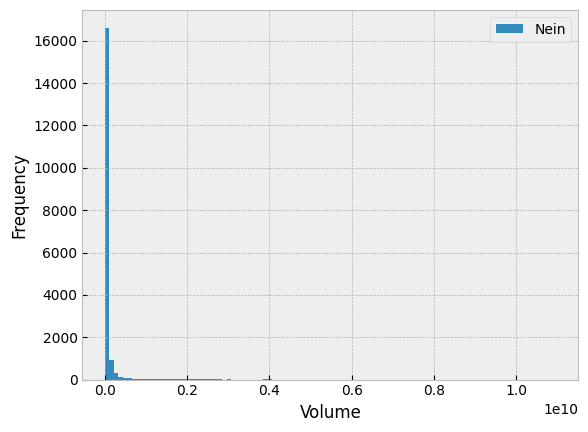

In [66]:
df_new = df[(df['X-Min'] != 0) & (df['X-Max'] != 0)]
visualize_volume(df_new)